<a href="https://colab.research.google.com/github/joo9906/AI_Track/blob/main/Team8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 필요한 라이브러리 다운로드

In [ ]:
!pip install -qU openai langchain langchain-upstage langchain-chroma getpass4

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.0/755.0 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 100.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━

# Upstage API Key 입력

In [ ]:
# @title set API key
import os
import getpass
import warnings

warnings.filterwarnings("ignore")

# Get the Upstage API key using getpass
if "UPSTAGE_API_KEY" not in os.environ or not os.environ["UPSTAGE_API_KEY"]:
    os.environ["UPSTAGE_API_KEY"] = getpass.getpass("Enter your Upstage API key: ")

print("API key has been set successfully.")

Enter your Upstage API key: ··········
API key has been set successfully.


# csv -> Vector
## 문단 리스트 준비

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.schema import Document
import pandas as pd
from typing import List

# patients.csv 읽기 (환자 기본 정보)
df = pd.read_csv("patients.csv")

# csv에서 사례화
def row_to_text(row) -> str:
    text = (
        f"PATIENT_ID: {row['Id']} 환자는, "
        f"{row['BIRTHDATE']}에 태어났고, 성별은 {row['GENDER']}, 인종은 {row['RACE']}, 민족성은 {row['ETHNICITY']}입니다."
        # 나이 추가할 것
    )
    return text

texts = df.apply(row_to_text, axis=1).tolist()

# 문서 리스트 준비
patient_docs = []
for _, row in df.iterrows():
    text = row_to_text(row)
    patient_docs.append(Document(page_content=text, metadata={"patient_id": row["Id"]}))

In [ ]:
# conditions.csv 읽기 (환자 진단 질병 정보)
df = pd.read_csv("conditions.csv")

# csv에서 사례화
def row_to_text(row) -> str:
    text = (
        f"PATIENT_ID: {row['PATIENT']} 환자는, "
        f"{row['START']}부터 {row['STOP']}까지 질병 코드: {row['CODE']}, {row['DESCRIPTION']}을 진단 받았습니다."
    )
    return text

texts = df.apply(row_to_text, axis=1).tolist()

# 문서 리스트 준비
conditions_docs = []
for _, row in df.iterrows():
    text = row_to_text(row)
    conditions_docs.append(Document(page_content=text, metadata={"patient_id": row["Id"]}))

SyntaxError: unterminated string literal (detected at line 8) (ipython-input-29-1818963096.py, line 8)

## Chunking 작업

In [ ]:
# Splitter 설정
patient_text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=0,
)

# 실제 split
patient_splits = patient_text_splitter.split_documents(patient_docs)

# 결과 출력
print("Splits:", len(patient_splits))


Splits: 1182


## Plot 시각화

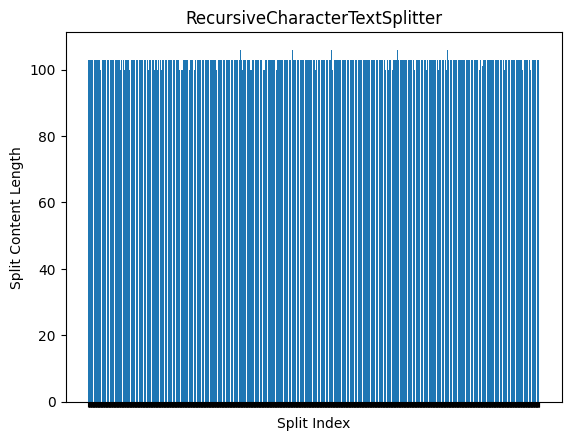

In [ ]:
# 시각화
import matplotlib.pyplot as plt

split_lengths = [len(split.page_content) for split in patient_splits]
# split_lengths = [len(split.page_content) for split in splits2]
# split_lengths = [len(split.page_content) for split in splits3]

plt.bar(range(len(split_lengths)), split_lengths)
plt.title("RecursiveCharacterTextSplitter")
plt.xlabel("Split Index")
plt.ylabel("Split Content Length")
plt.xticks(range(len(split_lengths)), [])
plt.show()

## Vector DB 저장

In [ ]:
from langchain_chroma import Chroma
from langchain_upstage import UpstageEmbeddings
from langchain.docstore.document import Document

# 1️⃣ Embeddings 객체 선언
embeddings = UpstageEmbeddings(model="embedding-query")

# 2️⃣ Chroma 벡터 DB 생성 및 문서 삽입
patient_vectorstore = Chroma.from_documents(
    documents=patient_splits,
    embedding=embeddings
)

ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientStartEvent: capture() takes 1 positional argument but 3 were given
ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event ClientCreateCollectionEvent: capture() takes 1 positional argument but 3 were given


# LLM 생성

In [ ]:
# ✅ Dense Retriever 생성
patient_retriever = patient_vectorstore.as_retriever(
    search_type='mmr',
    search_kwargs={'k': 1},
)

# ✅ 사용자의 한국어 질문 예시
query = "환자 중에 아시아 사람의 신상 정보를 알려줘."

# ✅ 검색된 문서 가져오기
patient_docs = patient_retriever.invoke(query)

# all_context = "\n".join([
#     doc.page_content for doc in (patient_docs + diagnosis_docs + medication_docs)
# ])
all_context = "\n".join([
    doc.page_content for doc in (patient_docs)
])

# ✅ 한국어 system 프롬프트 정의
from langchain_upstage import ChatUpstage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

llm = ChatUpstage()

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            당신은 환자 정보에 대한 질문에 친절히 답변하는 한국어 의료 AI 어시스턴트입니다.
            아래 CONTEXT 정보를 참고하여 환자 정보를 자연스럽게 한국어로 풀어서 설명해 주세요.
            각 컬럼명(예: Race, Gender 등)은 한국어로 번역해 사용하고, 대화체 톤으로 작성해 주세요.
            표나 리스트 형태보다는 문단 형태로 정리해 주세요.
            모르면 모른다고 솔직히 답변하세요.
            ---
            CONTEXT:
            {context}
            """,
        ),
        ("human", "{input}"),
    ]
)

# ✅ LLM chain 구성
chain = prompt | llm | StrOutputParser()

# ✅ 최종 chain 호출
response = chain.invoke({"context": all_context, "input": query})

print("\n💬 AI의 답변:")
print(response)


ERROR:chromadb.telemetry.product.posthog:Failed to send telemetry event CollectionQueryEvent: capture() takes 1 positional argument but 3 were given



💬 AI의 답변:
환자 중에 아시아인의 신상 정보를 알려드리겠습니다. 환자 번호 4bbf653e-3646-6bd6-229c-a45b80596ca2의 환자는 아시아인으로, 2003년 5월 31일에 태어났어요. 성별은 남성이고, 민족성은 nonhispanic입니다. 이 환자 외에 다른 아시아인 환자의 정보를 알고 싶으시다면, 더 구체적인 정보나 조건이 필요합니다. 그러면 그에 맞춰서 정보를 찾아드릴 수 있을 거예요!


TMI: 여기까지 돌리는 데 Billing 0.05$ 사용
### Now What?
GPT 추천:
# ✅ 💡 선택지 크게 두 가지

## 🅰️ **전부 조인 후 넣기 (One big chunk)**

### ✔️ 장점

* 환자 한 명에 대한 정보가 하나의 청크에 모두 담김 → 질문할 때 정확한 컨텍스트 제공
* 질병, 약물, 투약 주의사항 등을 한 번에 설명하기 쉬움

### ❌ 단점

* row 폭발 (조인한 경우 레코드 수 \* 약물 수 \* 진단 수 …)
* 청크가 너무 커짐 → 나눠야 할 때 문맥이 깨짐
* 관리/업데이트 어려움

---

## 🅱️ **테이블별로 분리, Retriever에서 동적 컨텍스트 결합 (멀티-벡터 전략)**

### ✔️ 장점

* 각 테이블 정보 독립적으로 유지
* 스케일 확장 유리 (예: 약물 DB 업데이트, 질환 DB 변경 등)
* Retriever 단계에서 동적으로 "다중 소스" 컨텍스트 결합 가능

### ❌ 단점

* QA 정확도를 높이려면 "적절한 컨텍스트 조합 로직" 필요
* LLM 프롬프트 설계가 복잡

---

# ✅ 💡 현업과 연구에서 많이 쓰는 전략: **멀티-벡터 & 멀티-Retriever 방식**

### 💡 구조

```
[벡터 DB A] ← 환자 정보 테이블 (예: Patient Demographics)
[벡터 DB B] ← 질병 정보 테이블 (예: Diagnoses)
[벡터 DB C] ← 약물 정보 테이블 (예: Medications)
```

---

## ✅ 1️⃣ 각 테이블별로 개별 벡터 DB 구축

* 각 테이블 row 단위로 Document 생성 → 독립 embedding
* 예:

```python
patient_docs = [Document(page_content="환자 A: 60세, 남성, 당뇨, 고혈압", metadata={"patient_id": "A"})]
diagnosis_docs = [Document(page_content="환자 A: 진단명: 당뇨병, HbA1c: 8.5%", metadata={"patient_id": "A"})]
medication_docs = [Document(page_content="환자 A: 메트포르민 투약 중", metadata={"patient_id": "A"})]
```

---

## ✅ 2️⃣ Retriever 여러 개 선언

```python
patient_retriever = patient_vectorstore.as_retriever(search_kwargs={'k': 1})
diagnosis_retriever = diagnosis_vectorstore.as_retriever(search_kwargs={'k': 1})
medication_retriever = medication_vectorstore.as_retriever(search_kwargs={'k': 1})
```

---

## ✅ 3️⃣ 질문 시, **각 Retriever에서 병렬 검색 → 결과 컨텍스트 합침**

```python
patient_docs = patient_retriever.invoke(query)
diagnosis_docs = diagnosis_retriever.invoke(query)
medication_docs = medication_retriever.invoke(query)

all_context = "\n".join([
    doc.page_content for doc in (patient_docs + diagnosis_docs + medication_docs)
])
```

---

## ✅ 4️⃣ LLM에 합쳐진 context 전달

```python
response = chain.invoke({"context": all_context, "input": query})
```

---

# ✅ 💬 **실제 사용 시 포인트**

| 고려 사항         | 내용                                                                      |
| ------------- | ----------------------------------------------------------------------- |
| ✅ 컨텍스트 길이     | 여러 테이블 합치면 길어질 수 있음 → 필요하면 각 테이블에서 `k` 값을 줄이거나 요약 추가                    |
| ✅ metadata 활용 | `patient_id`, `diagnosis_id` 등으로 cross-link → 필터 기반 검색 강화 가능            |
| ✅ 프롬프트 설계     | "아래에 환자 기본정보, 질병정보, 약물정보가 있습니다. 이 환자에게 적합한 약물과 투약 시 주의사항을 종합적으로 알려주세요." |

---

# ✅ ✅ 💡 **요약**

### 💡 다 조인? ❌

* 데이터 폭발, 관리 불가

### 💡 테이블별 분리 & Retriever에서 조합? ✅

* 유연, scalable, 관리 쉽고, 정확도 높음

---